In [1]:
# Pairs Trading is also called spread trading strategy
# find two stocks with hedging effect
# hedging, due to historical trend, the total returns will be at a certain level
# so we expect it to reverse to a normal level and then make corresponding operations

In [2]:
# pairs trading just care about the spread of two different stocks
# do not care about single stock or the whole market
# spread of the 2 stocks has some kind of equilibrium value

In [3]:
# procedure
# formation period (pick stocks) & trading period (implementation)

In [4]:
# I. selecting stock pair
#    find a pair of stocks which have stable spread in history
#    we can not trail one by one, we have to trail inside a subspace of the whole market
#    (1) inter-industry matching
#    (2) inter-industrial chain matching
#    (3) financial point of view (similar PE ratio, etc.)

In [8]:
#    we use qualitative method to select subspace, then we need quantitative method to measure it
#    (1) least distance mtd
#        the sum of ^2 of accumulated returns (standardized price) difference
import pandas as pd
import numpy as np
sh=pd.read_csv('sh50p.csv',index_col='Trddt')
sh.index=pd.to_datetime(sh.index)
# define formation period
formStart='2014-01-01'
formEnd='2015-01-01'
# data on formation period
shform=sh[formStart:formEnd]
shform.head(2)

,600000,600010,600015,600016,600018,600028,600030,600036,600048,600050,...,601688,601766,601800,601818,601857,601901,601985,601988,601989,601998
Trddt,,,,,,,,,,,,,,,,,,,,,
2014-01-02,8.307,2.360,6.371,6.183,5.031,4.117,12.288,9.719,5.156,3.146,...,8.534,4.869,3.781,2.383,7.245,5.91,-,2.333,5.617,3.634
2014-01-03,8.138,2.594,6.187,6.087,4.906,4.043,11.937,9.520,5.112,3.088,...,8.293,4.791,3.725,2.356,7.217,5.91,-,2.289,5.517,3.578


In [9]:
# take out Bank of China's  and PuFa Bank's data and concate them
PAf=shform['601988']
PBf=shform['600000']
pairf=pd.concat([PAf,PBf],axis=1)
len(pairf)

245

In [10]:
# compute the 'distance'
def SSD(priceX,priceY):
    if priceX is None or priceY is None:
        print('lack price series')
    returnX=(priceX-priceX.shift(1))/priceX.shift(1)[1:]
    returnY=(priceY-priceY.shift(1))/priceY.shift(1)[1:]
    standardX=(returnX+1).cumprod()
    standardY=(returnY+1).cumprod()
    SSD=np.sum((standardX-standardY)**2)
    return SSD
dis=SSD(PAf,PBf)
dis
# Pairwise coupling these stocks inside SH50 Index, we get 1225 pairs, pick the smallest 5 pairs

0.47481704588389073

In [11]:
#    (2) cointegration pair mtd
#        the log price is always 1st order integrated, or the log return is stationary
from arch.unitroot import ADF
PAflog=np.log(PAf)
adfA=ADF(PAflog)
print(adfA.summary().as_text())
# below shows non-stationary property

True
   Augmented Dickey-Fuller Results   
Test Statistic                  3.409
P-value                         1.000
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [12]:
# 1st difference
retA=PAflog.diff()[1:]
adfretA=ADF(retA)
print(adfretA.summary().as_text())
# stationary, so original one is 1st integrated

True
   Augmented Dickey-Fuller Results   
Test Statistic                 -4.571
P-value                         0.000
Lags                               11
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [13]:
# same analysis for another stock
PBflog=np.log(PBf)
adfB=ADF(PBflog)
print(adfB.summary().as_text())

True
   Augmented Dickey-Fuller Results   
Test Statistic                  2.392
P-value                         0.999
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [14]:
retB=PBflog.diff()[1:]
adfretB=ADF(retB)
print(adfretB.summary().as_text())

True
   Augmented Dickey-Fuller Results   
Test Statistic                 -3.888
P-value                         0.002
Lags                               11
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Text(0.5,1,'comparison between two stocks w.r.t. time')

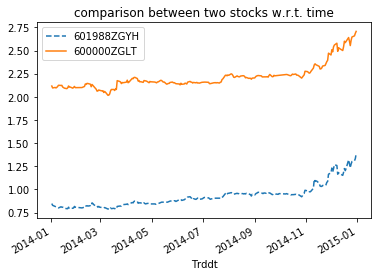

In [16]:
import matplotlib.pyplot as plt 
PAflog.plot(label='601988ZGYH',style='--')
PBflog.plot(label='600000ZGLT',style='-')
plt.legend(loc='upper left')
plt.title('comparison between two stocks w.r.t. time')
# very similar tendency of prices, but not stationary

Text(0.5,1,'comparison between two stocks (log difference) w.r.t. time')

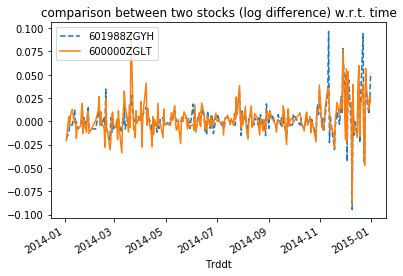

In [17]:
retA.plot(label='601988ZGYH',style='--')
retB.plot(label='600000ZGLT',style='-')
plt.legend(loc='upper left')
plt.title('comparison between two stocks (log difference) w.r.t. time')
# very similar tendency of prices, and stationary

In [18]:
# when two logX / logY are 1st order integrated
# use simple OLS regression model to test their relationships
import statsmodels.api as sm
model=sm.OLS(PBflog,sm.add_constant(PAflog))
results=model.fit()
print(results.summary())
# intercept and coef are all significant

                            OLS Regression Results                            
Dep. Variable:                 600000   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     4560.
Date:                Mon, 22 Oct 2018   Prob (F-statistic):          1.83e-159
Time:                        16:25:10   Log-Likelihood:                 509.57
No. Observations:                 245   AIC:                            -1015.
Df Residuals:                     243   BIC:                            -1008.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2269      0.015     83.071      0.0

In [19]:
# test residues
alpha=results.params[0]
beta=results.params[1]
# compute residues
spread=PBflog-beta*PAflog-alpha
spread.head(3)

Trddt
2014-01-02   -0.011214
2014-01-03   -0.011507
2014-01-06    0.006511
dtype: float64

Text(0.5,1,'spread series')

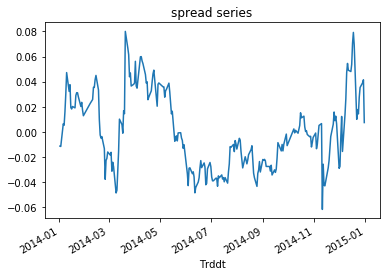

In [20]:
spread.plot()
plt.title('spread series')

In [21]:
# unitroot test
# 'nc' means no intercept
adfSpread=ADF(spread,trend='nc')
print(adfSpread.summary().as_text())
# so residues are stationary
# so 2 stocks are cointegration 

True
   Augmented Dickey-Fuller Results   
Test Statistic                 -3.199
P-value                         0.001
Lags                                0
-------------------------------------

Trend: No Trend
Critical Values: -2.57 (1%), -1.94 (5%), -1.62 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [22]:
# II. making strategies
#    (1) least distance mtd
#        after selecting stocks by least distance mtd, compute the mean and var of logprice diff
#        the signal is \mu+-1.2\sigma
#        for instance, when the spread rise, we short high stock and buy low stock
#        the spread will reverse back to normal then reverse operation, winning!!!
#    First, we have to compute various stats and decide open or close positions
standardA=(1+retA).cumprod()
standardB=(1+retB).cumprod()
SSD_pair=standardB-standardA
SSD_pair.head(3)

Trddt
2014-01-03   -0.001514
2014-01-06    0.015407
2014-01-07    0.013962
dtype: float64

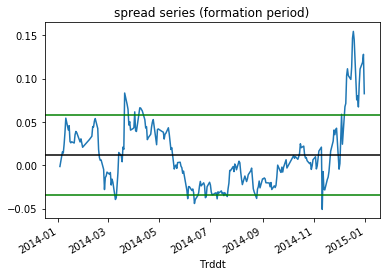

In [24]:
meanSSD_pair=np.mean(SSD_pair)
sdSSD_pair=np.std(SSD_pair)
thresholdUp=meanSSD_pair+1.2*sdSSD_pair
thresholdDown=meanSSD_pair-1.2*sdSSD_pair
SSD_pair.plot()
plt.title('spread series (formation period)')
plt.axhline(y=meanSSD_pair,color='black')
plt.axhline(y=thresholdUp,color='green')
plt.axhline(y=thresholdDown,color='green')
# this is all about formation period

In [25]:
#    Second, in trading period, we use the strategy mentioned before
tradStart='2015-01-01'
tradEnd='2015-06-30'
PAt=sh.loc[tradStart:tradEnd,'601988']
PBt=sh.loc[tradStart:tradEnd,'600000']
def spreadCal(x,y):
    retx=(x-x.shift(1))/x.shift(1)[1:]
    rety=(y-y.shift(1))/y.shift(1)[1:]
    standardX=(1+retx).cumprod()
    standardY=(1+rety).cumprod()
    spread=standardX-standardY
    return(spread)
TradSpread=spreadCal(PBt,PAt).dropna()
TradSpread.describe()

count    118.000000
mean       0.001064
std        0.054323
min       -0.127050
25%       -0.028249
50%        0.005682
75%        0.041375
max        0.100249
dtype: float64

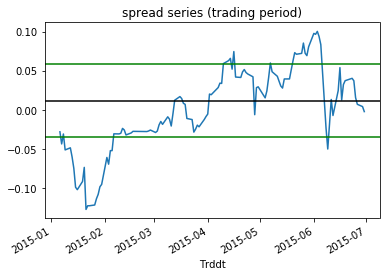

In [26]:
TradSpread.plot()
plt.title('spread series (trading period)')
plt.axhline(y=meanSSD_pair,color='black')
plt.axhline(y=thresholdUp,color='green')
plt.axhline(y=thresholdDown,color='green')

In [28]:
#    (2) cointegration pair mtd
#        new spread is the residue of the model between two log prices
spreadf=PBflog-beta*PAflog-alpha
mu=np.mean(spreadf)
sd=np.std(spreadf)
# trading period
CoSpreadT=np.log(PBt)-beta*np.log(PAt)-alpha
CoSpreadT.describe()

count    119.000000
mean      -0.037295
std        0.052204
min       -0.163903
25%       -0.063038
50%       -0.033336
75%        0.000503
max        0.057989
dtype: float64

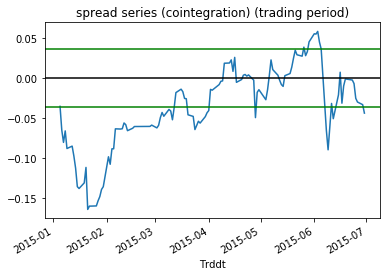

In [29]:
CoSpreadT.plot()
plt.title('spread series (cointegration) (trading period)')
plt.axhline(y=mu,color='black')
plt.axhline(y=mu+1.2*sd,color='green')
plt.axhline(y=mu-1.2*sd,color='green')
# a little bit differnt from the former strategy